In [20]:
# Total number of emails sent
total_emails = email_df['email_id'].nunique()

# Total opened and clicked
total_opened = email_opened_df['email_id'].nunique()
total_clicked = link_clicked_df['email_id'].nunique()

# Calculate percentages
open_rate = (total_opened / total_emails) * 100
click_rate = (total_clicked / total_emails) * 100

print(f" Total Emails Sent: {total_emails}")
print(f" Emails Opened: {total_opened} ({open_rate:.2f}%)")
print(f" Links Clicked: {total_clicked} ({click_rate:.2f}%)")


 Total Emails Sent: 100000
 Emails Opened: 10345 (10.35%)
 Links Clicked: 2119 (2.12%)


In [21]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load data
email_df = pd.read_csv("email_table.csv")
opened_df = pd.read_csv("email_opened_table.csv")
clicked_df = pd.read_csv("link_clicked_table.csv")

# Add flags to email_table
email_df['opened'] = email_df['email_id'].isin(opened_df['email_id']).astype(int)
email_df['clicked'] = email_df['email_id'].isin(clicked_df['email_id']).astype(int)

# One-hot encode categorical variables
X = pd.get_dummies(email_df.drop(columns=['email_id', 'clicked']), drop_first=True)
y = email_df['clicked']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.99      0.99     29326
           1       0.28      0.14      0.19       674

    accuracy                           0.97     30000
   macro avg       0.63      0.57      0.59     30000
weighted avg       0.96      0.97      0.97     30000



In [22]:
import xgboost as xgb
from sklearn.metrics import classification_report

# Convert dataset to DMatrix (optional, but efficient)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),  # Handle imbalance
    'seed': 42
}

# Train model
bst = xgb.train(params, dtrain, num_boost_round=100)

# Predict
y_pred_xgb = (bst.predict(dtest) > 0.5).astype(int)
print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       1.00      0.93      0.96     29326
           1       0.22      0.86      0.35       674

    accuracy                           0.93     30000
   macro avg       0.61      0.90      0.66     30000
weighted avg       0.98      0.93      0.95     30000



In [23]:
import pandas as pd

# Load datasets
email_df = pd.read_csv("email_table.csv")
opened_df = pd.read_csv("email_opened_table.csv")
clicked_df = pd.read_csv("link_clicked_table.csv")

# Add labels
email_df['opened'] = email_df['email_id'].isin(opened_df['email_id']).astype(int)
email_df['clicked'] = email_df['email_id'].isin(clicked_df['email_id']).astype(int)

# Segment click rates
def segment_analysis(df, groupby_col):
    return df.groupby(groupby_col)['clicked'].agg(['count', 'sum', 'mean']).rename(
        columns={'count': 'Emails Sent', 'sum': 'Total Clicks', 'mean': 'CTR (Click Rate)'}
    ).sort_values(by='CTR (Click Rate)', ascending=False)

# Example: by country
print("Click Rate by Country")
print(segment_analysis(email_df, 'user_country'))

# Example: by email version
print("\nClick Rate by Email Version")
print(segment_analysis(email_df, 'email_version'))

# Add more: weekday, email_text, etc.


Click Rate by Country
              Emails Sent  Total Clicks  CTR (Click Rate)
user_country                                             
UK                  19939           492          0.024675
US                  60099          1464          0.024360
ES                   9967            83          0.008327
FR                   9995            80          0.008004

Click Rate by Email Version
               Emails Sent  Total Clicks  CTR (Click Rate)
email_version                                             
personalized         49791          1359          0.027294
generic              50209           760          0.015137


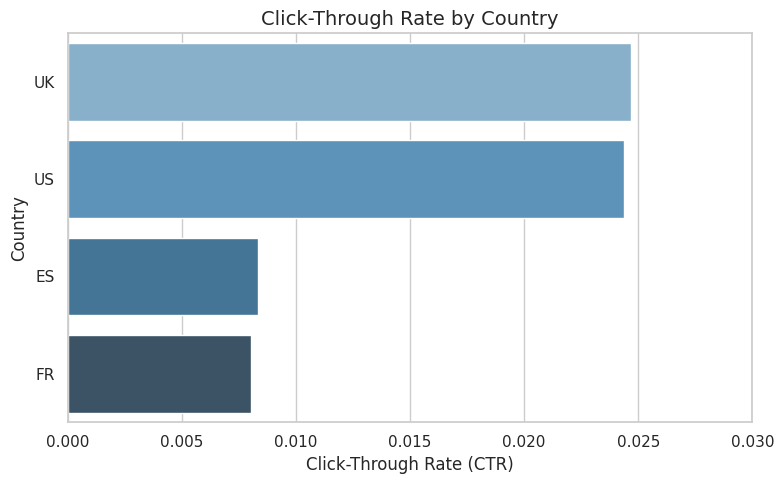

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Prepare data
country_ctr = email_df.groupby('user_country')['clicked'].mean().sort_values(ascending=False).reset_index()

# Plot: no emoji in title, no deprecated palette use
sns.barplot(x='clicked', y='user_country', data=country_ctr, hue='user_country', dodge=False, palette='Blues_d', legend=False)
plt.title("Click-Through Rate by Country", fontsize=14)
plt.xlabel("Click-Through Rate (CTR)")
plt.ylabel("Country")
plt.xlim(0, 0.03)  # Adjust based on range
plt.tight_layout()
plt.show()


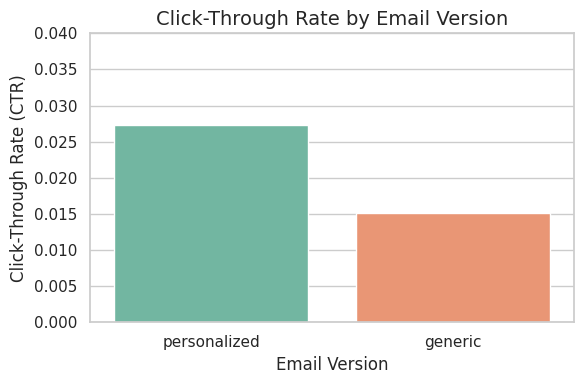

In [25]:
plt.figure(figsize=(6, 4))
version_ctr = email_df.groupby('email_version')['clicked'].mean().sort_values(ascending=False).reset_index()

sns.barplot(x='email_version', y='clicked', data=version_ctr, hue='email_version', dodge=False, palette='Set2', legend=False)
plt.title("Click-Through Rate by Email Version", fontsize=14)
plt.xlabel("Email Version")
plt.ylabel("Click-Through Rate (CTR)")
plt.ylim(0, 0.04)
plt.tight_layout()
plt.show()
